In [1]:
# These are standard modules
import time
import numpy as np
from scipy import linalg
from scipy import signal
import sympy as sym
import matplotlib.pyplot as plt
from IPython.display import display, Latex, Markdown

# This is a custom interface to the pybullet simulator
import ae353_platform_nonlinearsensors

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

pybullet build time: Jan 28 2022 20:18:15


In [2]:
# distance from platform axis to wheel axis
l = 1.

# radius of wheel
rw = 0.5

# mass of wheel
mw = 0.25

# moi of wheel
Jw = 0.5 * mw * rw**2

# mass of platform
mp = 12. * (1. - mw * l**2) / (3.**2 + 2.**2)

# moment of inertia of platform
Jp = (1. / 12.) * mp * (3.**2 + 2.**2)

# gravity
g = 9.81

# composite parameters
J1 = Jp + mw * l**2
J2 = Jw

In [3]:
simulator = ae353_platform_nonlinearsensors.Simulator(
    display=True,
    roll=0.,
    sensor_noise=0.,
)

argv[0]=--width=640
argv[1]=--height=480
Version = 4.1 INTEL-16.4.5
Vendor = Intel Inc.
Renderer = Intel(R) Iris(TM) Plus Graphics OpenGL Engine
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started


In [11]:
# Define a function to return a state-space model for a given choice of equilibrium point.
def get_dynamic_model(q1e, v1e, taue):
    # Define variables
    q1, v1, tau = sym.symbols('q1, v1, tau')
    
    # Define right-hand side of ODEs
    f = sym.Matrix([
        v1,
        (1 / J1) * tau,
    ])

    # Convert floating-point to rational numbers
    f = sym.nsimplify(f, rational=True)
    
    # Verify equilibrium point
    f_num = sym.lambdify([q1, v1, tau], f)
    if not np.allclose(f_num(q1e, v1e, taue), 0.):
        raise Exception('equilibrium point is invalid')
    
    # Find A and B in symbolic form
    A_sym = f.jacobian([q1, v1])
    B_sym = f.jacobian([tau])

    # Create lambda functions to allow numerical evaluation of A and B
    A_num = sym.lambdify([q1, v1, tau], A_sym)
    B_num = sym.lambdify([q1, v1, tau], B_sym)

    # Find A and B in numeric form (making sure the result is floating-point)
    A = A_num(q1e, v1e, taue).astype(float)
    B = B_num(q1e, v1e, taue).astype(float)

    # Return A and B
    return A, B

q1e = 0.
v1e = 0.
taue = 0.

A,B = get_dynamic_model(q1e, v1e, taue)
print(f'A =\n{A}\n\nB =\n{B}')

    

A =
[[0. 1.]
 [0. 0.]]

B =
[[0.]
 [1.]]


In [15]:
# Define a function to return a state-space model for a given choice of equilibrium point.
def get_sensor_model(q1e, v1e, taue):
    # Variables
    q1, v1, tau = sym.symbols('q1, v1, tau')

    # Outputs
    o = sym.Matrix([sym.sin(q1)])

    # Equilibrium
    o_num = sym.lambdify([q1, v1, tau], o)
    o_e = o_num(q1e, v1e, taue)
    C_num = sym.lambdify([q1, v1, tau], o.jacobian([q1, v1]))
    C = C_num(q1e, v1e, taue)
    return C
    
C = get_sensor_model(q1e, v1e, taue)
print(f'\nC =\n{C}')


C =
[[1. 0.]]


In [16]:
# Eigenvalue placement
K = signal.place_poles(A, B, [-2., -5.]).gain_matrix
print(f'K =\n{K}\n')

K =
[[10.  7.]]



In [17]:
Wo = np.block([[C], [C @ A]])
np.linalg.matrix_rank(Wo)

2

In [18]:
# Eigenvalue placement
L = signal.place_poles(A.T, C.T, [-2., -5.]).gain_matrix.T
print(f'L =\n{L}\n')

L =
[[ 7.]
 [10.]]



In [19]:
F = np.block([[A - B @ K, - B @ K],
              [np.zeros((2, 2)), A - L @ C]])

print(F)

[[  0.   1.   0.   0.]
 [-10.  -7. -10.  -7.]
 [  0.   0.  -7.   1.]
 [  0.   0. -10.   0.]]


In [20]:
print(linalg.eigvals(F))

[-2.+0.j -5.+0.j -5.+0.j -2.+0.j]


In [21]:
class Controller:
    def __init__(self, A, B, C, K, L, q1e, v1e, taue):
        self.dt = 0.01
        self.A = A
        self.B = B
        self.C = C
        self.K = K
        self.L = L
        self.q1e = q1e
        self.v1e = v1e
        self.taue = taue
        
        self.variables_to_log = ['xhat']
    
    def reset(self):
        self.xhat = np.array([0., 0.])
    
    def run(
            self,
            t,
            platform_angle_measurement,
        ):
        
        # Find input
        u = - self.K @ self.xhat
        
        # Find measurement
        y = np.array([np.sin(platform_angle_measurement) - np.sin(q1e)])
        
        # Find state estimate
        self.xhat += self.dt * (self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y))
        
        # Find actuator command
        tau = u[0] + self.taue
        
        wheel_torque = -tau
        return wheel_torque

In [22]:
# Create controller
controller = Controller(A, B, C, K, L, q1e, v1e, taue)

# Choose initial conditions
(q1i, v1i) = (0., 0.)

# Reset simulator
simulator.reset(
    platform_angle=q1i,
    platform_velocity=v1i,
    wheel_angle=0.,
    wheel_velocity=0.,
    sensor_noise=0.1,
)

# Reset controller
controller.reset()

# Run simulator
data = simulator.run(
    controller,
    max_time=10.,
)

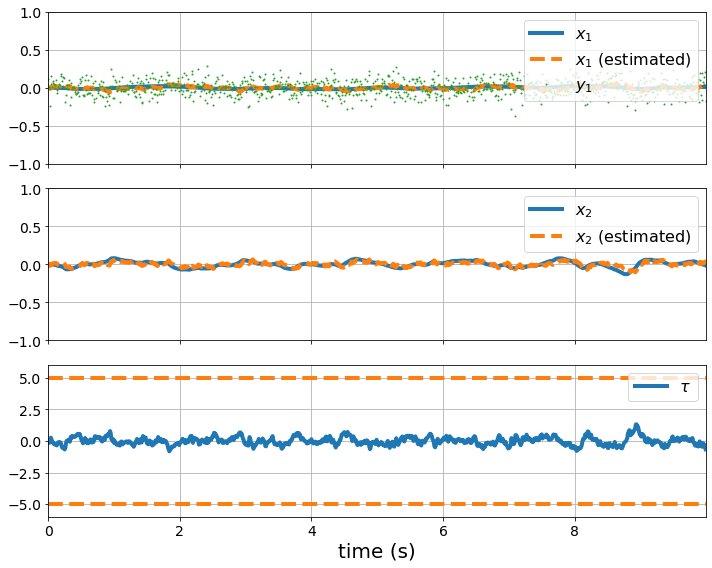

: 

In [23]:
t = data['t']
q1 = data['platform_angle']
v1 = data['platform_velocity']
tau = - data['wheel_torque']
q1_meas = data['platform_angle_measurement']
y1 = q1_meas - q1e
x1 = q1 - q1e
x2 = v1 - v1e
xhat = data['xhat']

fig, (ax_x1, ax_x2, ax_tau) = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

ax_x1.plot(t, x1, label='$x_1$', linewidth=4)
ax_x1.plot(t, xhat[:, 0], '--', label=r'$x_1$ (estimated)', linewidth=4)
ax_x1.plot(t, y1, '.', markersize=2, label='$y_1$')

ax_x2.plot(t, x2, label='$x_2$', linewidth=4)
ax_x2.plot(t, xhat[:, 1], '--', label=r'$x_2$ (estimated)', linewidth=4)

ax_tau.plot(t, tau, label=r'$\tau$', linewidth=4)
ax_tau.plot(t, simulator.tau_max * np.ones_like(t), '--', linewidth=4, color='C1')
ax_tau.plot(t, - simulator.tau_max * np.ones_like(t), '--', linewidth=4, color='C1')

ax_x1.grid()
ax_x1.legend(fontsize=16, loc='upper right')
ax_x1.tick_params(labelsize=14)
ax_x1.set_ylim(-1, 1)

ax_x2.grid()
ax_x2.legend(fontsize=16, loc='upper right')
ax_x2.tick_params(labelsize=14)
ax_x2.set_ylim(-1, 1)

ax_tau.grid()
ax_tau.legend(fontsize=16, loc='upper right')
ax_tau.tick_params(labelsize=14)
ax_tau.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

ax_tau.set_xlabel('time (s)', fontsize=20)
ax_tau.set_xlim([data['t'][0], data['t'][-1]])

fig.tight_layout()
plt.show()